## Load packages

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from io import BytesIO

## Settings

In [117]:
SEAFILE_PATH = os.path.abspath(os.path.join("../../../..", "Seafile", "Detecting-Objects", "DataCollection"))
IMAGE_PATH = os.path.join(SEAFILE_PATH, "images")
LABEL_PATH = os.path.join(SEAFILE_PATH, "labels")
OBJECT_CLASS = "bowl2"

OBJECT_PATH = os.path.join(IMAGE_PATH, OBJECT_CLASS)

RGB_IMAGE_PATH = os.path.join(OBJECT_PATH, "rgb")
DEPTH_IMAGE_PATH = os.path.join(OBJECT_PATH, "depth")

# Desk Coordinates
xmin, xmax, ymin, ymax = 340, 940, 60, 660

In [118]:
SEAFILE_PATH = os.path.abspath(os.path.join("../../../..", "Seafile", "Detecting-Objects", "DataCollection"))
IMAGE_PATH = os.path.join(SEAFILE_PATH, "images")

RGB_IMAGE_PATH = os.path.join(IMAGE_PATH, "gemittlet_diesmal_wirklich", "rgb")
DEPTH_IMAGE_PATH = os.path.join(IMAGE_PATH, "gemittlet_diesmal_wirklich", "depth")

In [5]:
def get_donut_image():
    # Create a new image with a black background
    width, height = 1280, 720
    image = Image.new("RGB", (width, height), "black")

    # Create a draw object to draw on the image
    draw = ImageDraw.Draw(image)

    # Define the center and size of the donut shape
    center_x, center_y = width/2, height/2
    outer_radius = 70
    inner_radius = 35

    # Draw the outer circle of the donut shape
    draw.ellipse((center_x-outer_radius, center_y-outer_radius, center_x+outer_radius, center_y+outer_radius), fill='white')

    # Draw the inner circle of the donut shape
    draw.ellipse((center_x-inner_radius, center_y-inner_radius, center_x+inner_radius, center_y+inner_radius), fill='black')
    
    buffer = BytesIO()
    image.save(buffer, format='png')
    buffer.seek(0)
    
    return plt.imread(buffer)

In [119]:
def get_filtered_contours(contours):
    filtered_contours = []
    
    for contour in contours:
        x, y, w, h, = cv2.boundingRect(contour) 

        if w < 15 and h < 15:
            continue
            
        if w > 500 and h > 500:
            continue

        if x+w > xmax or y+h > ymax:
            pass

        if w*h < 500:
            pass 

        if w/h > 2:
            pass

        filtered_contours.append((x, y, x+w, y+h)) 
    return filtered_contours

In [120]:
def fill_holes(dilate):
    im_floodfill = dilate.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = donut_image.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (xmin + 10, ymin + 10), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    
    return cv2.bitwise_or(dilate, im_floodfill_inv)

In [121]:
def get_bounding_box(depth_img):
    # Remove pixels outside of table
    mask = np.zeros_like(depth_img)
    cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), (255, 255, 255), -1)

    CANNY_THRESH = 10
    KERNEL_SIZE = 5
    ITERATION_COUNT = 3
    
    edged = cv2.Canny(depth_img, CANNY_THRESH, CANNY_THRESH, CANNY_THRESH)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (KERNEL_SIZE, KERNEL_SIZE))
    dilate = cv2.dilate(edged, kernel, iterations=ITERATION_COUNT)
    dilate = cv2.bitwise_and(dilate, mask)

    dilate = fill_holes(dilate)
    
    # find the contours in the dilated image
    contours, _ = cv2.findContours(dilate, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[2:])
    
    _, axarr = plt.subplots(1, 2)
    axarr[0].imshow(dilate)
    axarr[1].imshow(depth_img)
    plt.show()

    filtered_contours = get_filtered_contours(contours)
    
    return filtered_contours[-1] if filtered_contours else []

In [124]:
def draw_boxes(object_name):
    xmin, xmax, ymin, ymax = 340, 940, 60, 660
    
    
    OBJECT_PATH = os.path.join(IMAGE_PATH, object_name)
    #RGB_IMAGE_PATH = os.path.join(OBJECT_PATH, "rgb")
    #DEPTH_IMAGE_PATH = os.path.join(OBJECT_PATH, "depth")
    
    RGB_IMAGE_PATH = os.path.join(IMAGE_PATH, "gemittlet_diesmal_wirklich", "rgb")
    DEPTH_IMAGE_PATH = os.path.join(IMAGE_PATH, "gemittlet_diesmal_wirklich", "depth")

    files = os.listdir(RGB_IMAGE_PATH)
    
    for file_name in files:
        # Read images
        rgb_img = cv2.imread(os.path.join(RGB_IMAGE_PATH, file_name), cv2.IMREAD_UNCHANGED).astype('uint8')
        depth_img = cv2.imread(os.path.join(DEPTH_IMAGE_PATH, file_name), cv2.IMREAD_UNCHANGED).astype('uint8')

        boxes = get_bounding_box(depth_img)        
        print(boxes)
        
        # Print boxes on image
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)     
        result = rgb_img.copy()
        
        if len(boxes) > 0:
            cv2.rectangle(result, (boxes[0], boxes[1]), (boxes[2], boxes[3]), (0, 255, 0), 1)
    
        plt.imshow(result)
        cv2.imwrite(os.path.join(RGB_IMAGE_PATH, "..", "annotation", file_name), cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

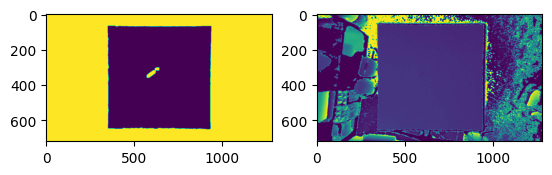

(570, 302, 642, 362)


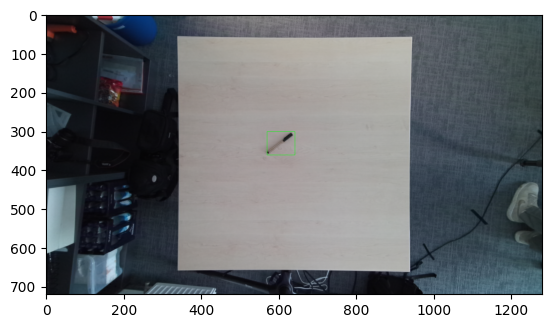

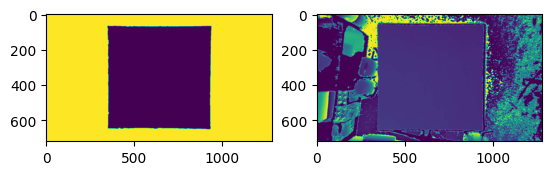

[]


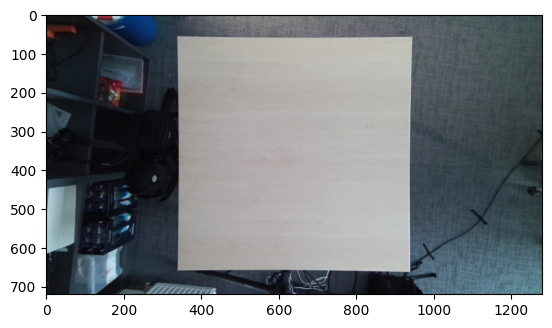

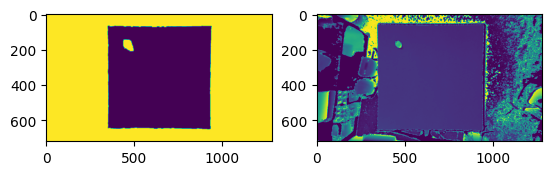

(437, 144, 497, 211)


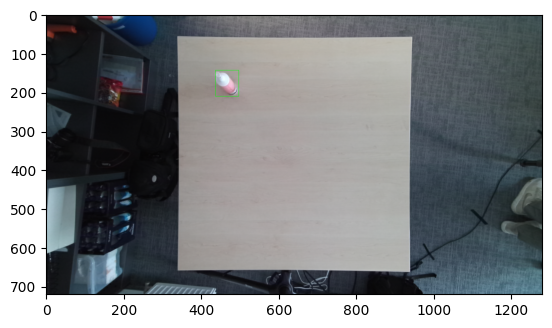

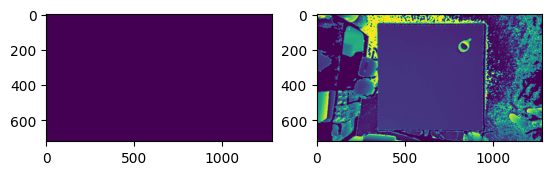

[]


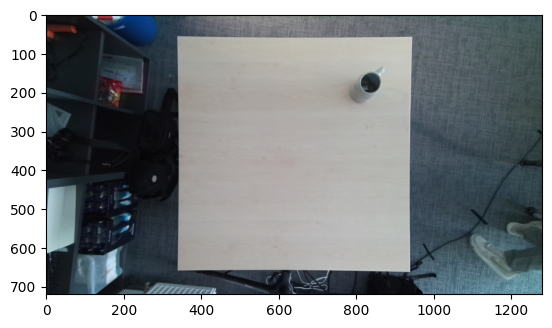

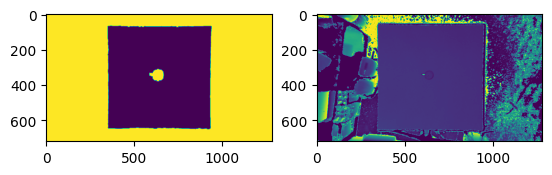

(585, 312, 667, 381)


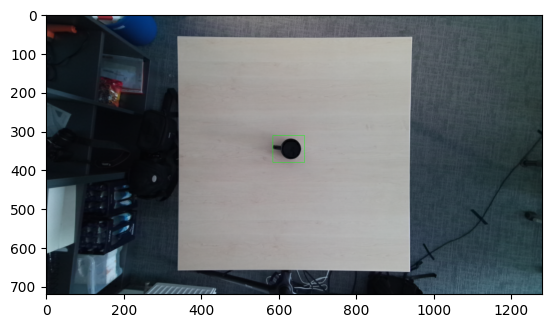

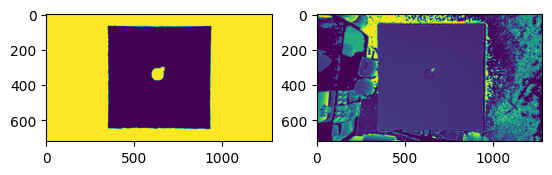

(598, 300, 672, 376)


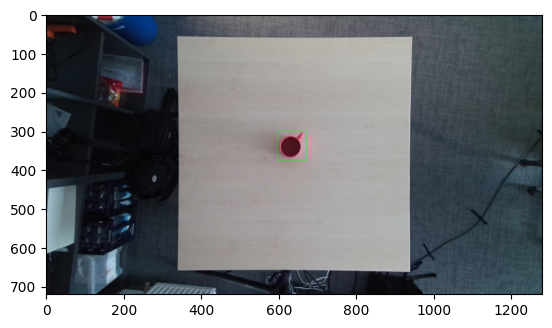

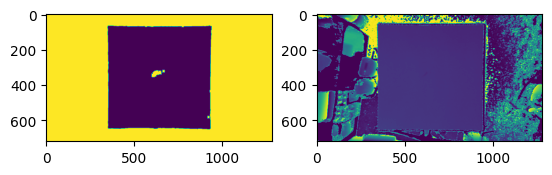

(598, 319, 655, 358)


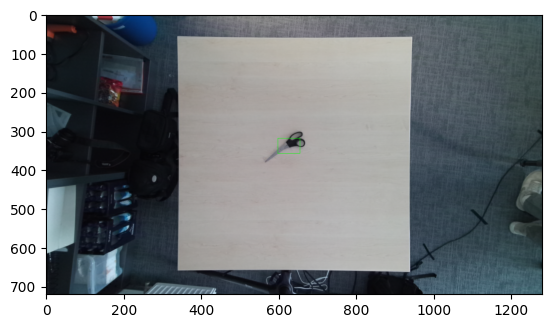

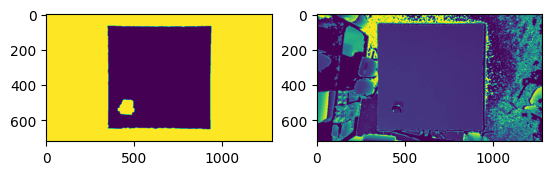

(406, 484, 502, 572)


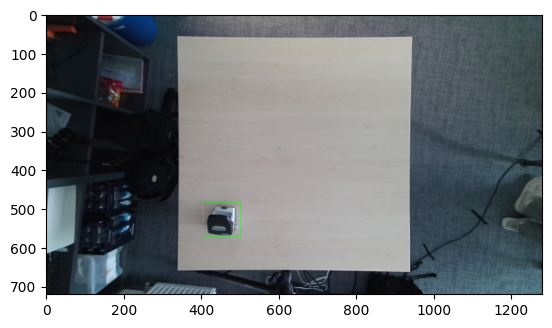

In [125]:
draw_boxes("cup")